In [18]:
import pathlib
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import normalize
import numpy as np
import pickle
from itertools import islice
import gzip
from prompter import Prompter
from chromadb.utils.embedding_functions import OllamaEmbeddingFunction
import chromadb
import matplotlib.pyplot as plt

In [19]:
import sys
import os
import pathlib
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy import sparse

In [20]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [21]:
def get_doc_top_tpcs(doc_distr, topn=10):
    sorted_tpc_indices = np.argsort(doc_distr)[::-1]
    top = sorted_tpc_indices[:topn].tolist()
    top_weight = [(k, doc_distr[k]) for k in top]
    return top_weight

def get_doc_main_topc(doc_distr):
    sorted_tpc_indices = np.argsort(doc_distr)[::-1]
    top = sorted_tpc_indices[:1][0]
    return top

In [22]:
path_source = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/source/corpus_rosie/passages/29_dec/all/df_1.parquet")
path_model = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/models/29_dec/all/poly_rosie_1_100")

In [23]:
raw = pd.read_parquet(path_source)

In [24]:
with open(path_model / "mallet_output" / "keys_EN.txt", 'r') as file:
    lines = file.readlines()
topic_keys = [line.strip() for line in lines]
topic_keys

['tuberculosis treatment patient drug resistance resistant infection therapy recommend regimen antibiotic malaria antimicrobial day treat milligram agent prophylaxis person',
 'image tomography magnetic resonance imaging ultrasound ray compute scan procedure technology body emission computed doctor contrast positron wave detect',
 'exposure lead chemical air expose level concentration gas poisoning environmental worker occupational toxic niosh material substance dust control carbon',
 'patient study clinical trial treatment receive therapy evidence survival chemotherapy rate evaluate follow response month outcome phase combination control',
 'kidney liver transplant hepatitis disease organ donor renal chronic acute failure hcv transplantation dialysis hbv damage stone bile function',
 'hiv sexual sex infection health organization partner contact person aids std testing infect transmit condom transmission risk gender prevention',
 'surgery procedure surgeon surgical remove perform repai

In [25]:
thetas = sparse.load_npz(path_model / "mallet_output" / "thetas_EN.npz").toarray()
S3 = sparse.load_npz(path_model / "mallet_output" / "s3_EN.npz").toarray()

In [26]:
betas = np.load(path_model / "mallet_output" / "betas_EN.npy")

In [27]:
# get weight of each word as maximum 
betas_word = np.max(betas, axis=0)
betas_word.shape
betas_word

array([1.43531562e-02, 6.78139992e-03, 2.68079852e-02, ...,
       1.41057650e-06, 1.24004400e-06, 1.52285114e-06], shape=(295258,))

In [28]:
ntopics = betas.shape[0]
size_vocab = betas.shape[1]
betas_ds = np.copy(betas)
if np.min(betas_ds) < 1e-12:
    betas_ds += 1e-12
deno = np.reshape((sum(np.log(betas_ds)) / ntopics), (size_vocab, 1))
deno = np.ones((ntopics, 1)).dot(deno.T)
betas_ds = betas_ds * (np.log(betas_ds) - deno)

In [29]:
# get weight of each word as maximum 
betas_word_ds = np.max(betas_ds, axis=0)
betas_word_ds.shape
betas_word_ds

array([2.65135925e-01, 1.11461697e-01, 6.37275295e-01, ...,
       1.97733550e-05, 1.72246611e-05, 2.14626739e-05], shape=(295258,))

In [30]:
df = pd.read_parquet(path_source)
df_lang = df[df["doc_id"].str.contains("EN")]

In [31]:
documents_texts = df_lang["lemmas"].apply(lambda x: x.split()).tolist()

vocab_w2id = {}
vocab_id2w = {}
with open(path_model / "mallet_output" / "vocab_EN.txt") as file:
    for i, line in enumerate(file):
        # Strip leading and trailing whitespace
        stripped_line = line.strip()
        # Split the line into words and numbers
        parts = stripped_line.split()
        if parts:
            # Get the word (first part)
            wd = parts[0]
            # Populate the dictionaries
            vocab_w2id[wd] = i
            vocab_id2w[str(i)] = wd

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine tokenized documents into strings for TfidfVectorizer
documents_texts = [' '.join(doc) for doc in df_lang["lemmas"].apply(lambda x: x.split()).tolist()]

# Use your existing vocabulary
custom_vocab = vocab_w2id if vocab_w2id else None

# Initialize the TfidfVectorizer with custom vocabulary (optional)
vectorizer = TfidfVectorizer(vocabulary=custom_vocab)

# Fit the vectorizer and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents_texts)

# Retrieve the column index of the word
def get_tfidf_value(word, doc_index):
    if word not in custom_vocab:
        raise ValueError(f"Word '{word}' is not in the vocabulary.")
    word_index = custom_vocab[word]  # Get the column index of the word
    tfidf_value = tfidf_matrix[doc_index, word_index]  # Access the sparse value
    return tfidf_value

In [71]:
df_lang["lemmas"].iloc[0]

'order avoid future allergic_reaction range vomit hive anaphylactic_shock rani family need remain_vigilant avoid exposure allergen time rani food option increase list food allergic grow'

In [72]:
# Example usage
word = "avoid"
tfidf_value = get_tfidf_value(word, 0)
tfidf_value

np.float64(0.3080845401525382)

In [107]:
df_lang["len"] = df_lang["lemmas"].apply(lambda x : len([word for word in x.split() if word in vocab_w2id]))

In [108]:
df_lang["len"]

0          19
1           8
2           1
3          33
4          11
           ..
1393092    11
1393093    10
1393094    81
1393095     3
1393096    18
Name: len, Length: 1393097, dtype: int64

In [110]:
df_lang[df_lang.len == 0].text

1205                                          OPERATOR: Thank you, John Lauerman with Bloomberg News, your line is now open.
1554                                               Colorless liquid or crystalline solid (below 63°F) with an aromatic odor.
1581             Available Meeting Items:\n- An agenda will be provided at a later date.\n- Transcript [987 KB (384 pages)].
4858       Reviewed on Nov 18, 2022: I can't say enough good things about Dr Anton, wish I would have come to him earlier!!!
5295                                                          Place all of the ingredients in a blender. Blend until smooth.
                                                                 ...                                                        
1384035                                                          Reviewed on Mar 28, 2023: Dr. Faradyan is always excellent.
1385099                                   OPERATOR: Thank you. Tom Maugh, with the Los Angeles Times, your line is now open.


In [116]:
documents_texts = df_lang["lemmas"].apply(lambda x: x.split()).tolist()

D = len(thetas)
doc_score = np.zeros((D, 1))

for doc in range(D):
    wd_ids = [vocab_w2id[word] for word in documents_texts[doc] if word in vocab_w2id]

    # Skip documents with no valid words
    if len(wd_ids) == 0:
        doc_score[doc] = 0  # Or any default score for empty documents
        continue

    denominator = np.log(len(wd_ids) + 1e-10)  # Small epsilon to prevent log(0)
    doc_score[doc] = np.sum(betas_word[wd_ids]) / denominator

In [99]:
print(f"Max value in betas_word: {np.max(betas_word)}")
print(f"Min value in betas_word: {np.min(betas_word)}")

doc_lengths = [len([word for word in documents_texts[doc] if word in vocab_w2id]) for doc in range(D)]
print(f"Minimum document length: {min(doc_lengths)}")
print(f"Maximum document length: {max(doc_lengths)}")

Max value in betas_word: 0.45017334602191533
Min value in betas_word: 1.0141936399916836e-06
Minimum document length: 0
Maximum document length: 847


In [117]:
doc_score.max()

np.float64(4501733087.969174)

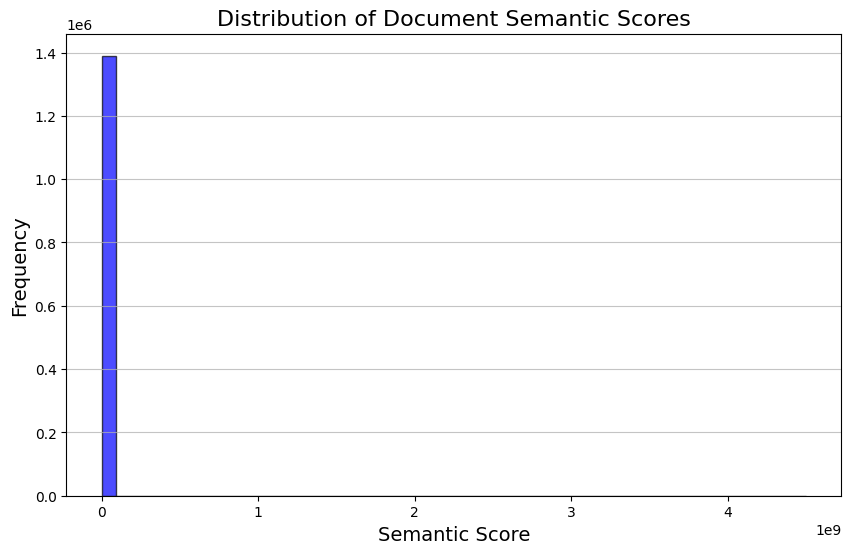

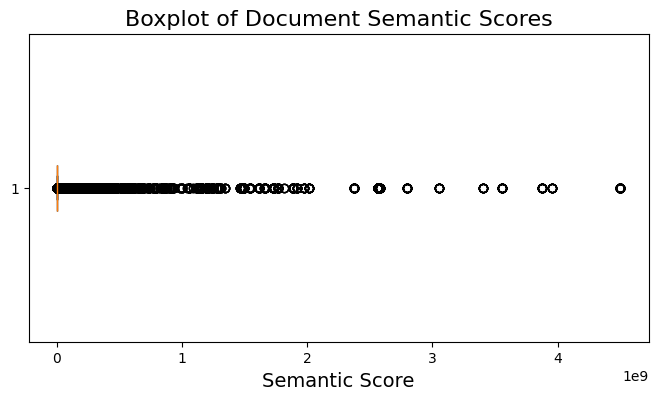

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Plot a histogram to show the distribution of scores
plt.figure(figsize=(10, 6))
plt.hist(doc_score, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Document Semantic Scores", fontsize=16)
plt.xlabel("Semantic Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Optional: Plot a boxplot to check for outliers
plt.figure(figsize=(8, 4))
plt.boxplot(doc_score, vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Boxplot of Document Semantic Scores", fontsize=16)
plt.xlabel("Semantic Score", fontsize=14)
plt.show()

In [90]:
# get weight of each word as maximum 
betas_word_ds = np.max(betas_ds, axis=0)
betas_word_ds.shape
betas_word_ds
D = len(thetas)
doc_score_ds = np.zeros((D, 1))

for doc in range(D):
    wd_ids = [vocab_w2id[word] for word in documents_texts[doc] if word in vocab_w2id]
    doc_score_ds[doc] = np.sum(betas_word_ds[wd_ids]) / np.log(len(wd_ids) + 1e-10)

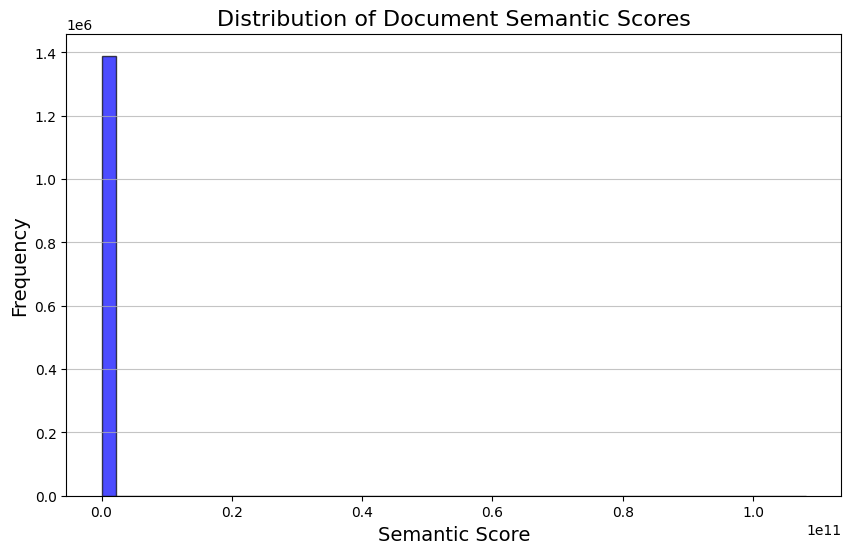

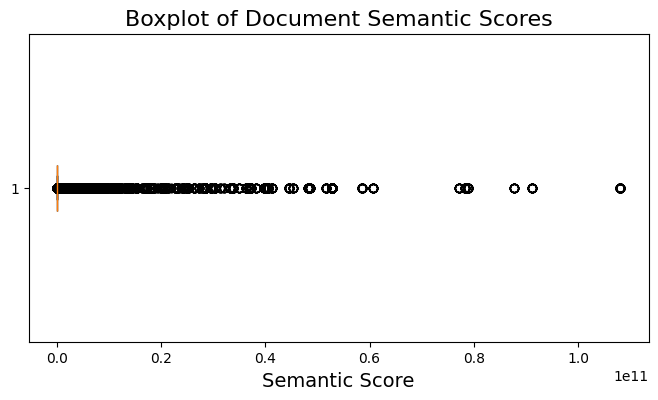

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Plot a histogram to show the distribution of scores
plt.figure(figsize=(10, 6))
plt.hist(doc_score_ds, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Document Semantic Scores", fontsize=16)
plt.xlabel("Semantic Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Optional: Plot a boxplot to check for outliers
plt.figure(figsize=(8, 4))
plt.boxplot(doc_score_ds, vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Boxplot of Document Semantic Scores", fontsize=16)
plt.xlabel("Semantic Score", fontsize=14)
plt.show()

In [92]:
np.max(doc_score_ds)

np.float64(108131085465.07437)

In [34]:
"""
D = len(documents_texts)  # Number of documents
doc_score = np.zeros((D, 1))

epsilon = 1e-10  # Small value to avoid division by zero in normalization

# Calculate document scores
for doc in range(D):
    # Get word IDs for words in the current document
    wd_ids = [vocab_w2id[word] for word in documents_texts[doc] if word in vocab_w2id]
    
    # Sum the word scores for this document
    total_score = np.sum(betas_word[wd_ids])
    
    # Normalize by document length or a function of it
    doc_length = len(wd_ids)
    normalized_score = total_score / (np.log(doc_length + epsilon) + 1)  # Add 1 to avoid division by zero
    
    # Store the normalized score
    doc_score[doc] = normalized_score
"""

'\nD = len(documents_texts)  # Number of documents\ndoc_score = np.zeros((D, 1))\n\nepsilon = 1e-10  # Small value to avoid division by zero in normalization\n\n# Calculate document scores\nfor doc in range(D):\n    # Get word IDs for words in the current document\n    wd_ids = [vocab_w2id[word] for word in documents_texts[doc] if word in vocab_w2id]\n    \n    # Sum the word scores for this document\n    total_score = np.sum(betas_word[wd_ids])\n    \n    # Normalize by document length or a function of it\n    doc_length = len(wd_ids)\n    normalized_score = total_score / (np.log(doc_length + epsilon) + 1)  # Add 1 to avoid division by zero\n    \n    # Store the normalized score\n    doc_score[doc] = normalized_score\n'

In [35]:
"""
betas_word_ds = np.max(betas_ds, axis=0)
D = len(documents_texts)  # Number of documents
doc_score_ds = np.zeros((D, 1))

epsilon = 1e-10  # Small value to avoid division by zero in normalization

# Calculate document scores
for doc in range(D):
    # Get word IDs for words in the current document
    wd_ids = [vocab_w2id[word] for word in documents_texts[doc] if word in vocab_w2id]
    
    # Sum the word scores for this document
    total_score = np.sum(betas_word_ds[wd_ids])
    
    # Normalize by document length or a function of it
    doc_length = len(wd_ids)
    normalized_score = total_score / (np.log(doc_length + epsilon) + 1)  # Add 1 to avoid division by zero
    
    # Store the normalized score
    doc_score_ds[doc] = normalized_score
"""

'\nbetas_word_ds = np.max(betas_ds, axis=0)\nD = len(documents_texts)  # Number of documents\ndoc_score_ds = np.zeros((D, 1))\n\nepsilon = 1e-10  # Small value to avoid division by zero in normalization\n\n# Calculate document scores\nfor doc in range(D):\n    # Get word IDs for words in the current document\n    wd_ids = [vocab_w2id[word] for word in documents_texts[doc] if word in vocab_w2id]\n    \n    # Sum the word scores for this document\n    total_score = np.sum(betas_word_ds[wd_ids])\n    \n    # Normalize by document length or a function of it\n    doc_length = len(wd_ids)\n    normalized_score = total_score / (np.log(doc_length + epsilon) + 1)  # Add 1 to avoid division by zero\n    \n    # Store the normalized score\n    doc_score_ds[doc] = normalized_score\n'

In [43]:
raw_en = raw[raw.doc_id.str.contains("EN")].copy()  

raw_en["thetas"] = list(thetas)
raw_en["betas_score"] = list(doc_score) #list(doc_score_ds)
raw_en["betas_ds_score"] = list(doc_score_ds) #list(doc_score_ds)
raw_en["top_k"] = raw_en["thetas"].apply(get_doc_top_tpcs)
raw_en["main_topic"] = raw_en["thetas"].apply(get_doc_main_topc)

In [47]:
np.percentile(doc_score_ds, 1)

np.float64(0.39942031891402985)

In [45]:
np.percentile(doc_score_ds, 95)

np.float64(45.496176838750515)

In [48]:
factor = 0.01
raw_en["keep_doc"] = raw_en.apply(lambda x: x["betas_ds_score"] >  0.39, axis=1)

In [54]:
raw_en[raw_en.keep_doc == False][["text", "main_topic", "betas_score", "betas_ds_score"]].head(50)

,text,main_topic,betas_score,betas_ds_score
216,Apply a topical steroid cream to the sting site to ease itching.,74,[0.008335547211213414],[0.1764870174394058]
865,Dictionary Definition: microbiome microbiome The microbes in your gastrointestinal tract that help with digestion. Also called gut flora.,41,[0.003433769469759193],[0.07018311816146323]
890,"OTC pain relievers, such as acetaminophen (Tylenol, others), ibuprofen (Advil, Motrin IB, others) or aspirin.",86,[0.010726536304673191],[0.23928509198969633]
1033,"Armstrong SR, Green LC. Chlorinated hydrocarbon solvents. Clin Occup Environ Med 2004;4(3):481-496.",45,[0.017616775279748868],[0.37411308916006936]
1205,"OPERATOR: Thank you, John Lauerman with Bloomberg News, your line is now open.",30,[0.0],[0.0]
1271,"Reviewed on Jul 25, 2022: Dana is the best. I feel so comfortable with her & appreciate how she listens to my concerns.",69,[0.00027035748236135457],[0.00486059725660976]
1355,CASEY: Excellent input Marcas thank you so much for that.,69,[0.017847975336457635],[0.3821643801645853]
1421,"Reviewed on Feb 13, 2023: Extremely happy with Dr. Schneider.",69,[0.004790836201097919],[0.10219527064103776]
1554,Colorless liquid or crystalline solid (below 63°F) with an aromatic odor.,2,[0.0],[0.0]
1581,Available Meeting Items:\n- An agenda will be provided at a later date.\n- Transcript [987 KB (384 pages)].,80,[0.0],[0.0]


In [46]:
raw_en[["text", "top_k", "main_topic", "betas_score", "betas_ds_score"]].sample(1000)#.to_excel("train_samples.xlsx")

,text,top_k,main_topic,betas_score,betas_ds_score
428113,"In each state, the prevalence of each behavior varied widely within each racial population. This indicates that a state's social and policy environment might affect a woman's risk for certain behaviors during pregnancy (33).","[(87, 0.4444444477558136), (71, 0.18518517911434174), (93, 0.07407407462596893), (98, 0.03703703731298447), (82, 0.03703703731298447), (46, 0.03703703731298447), (16, 0.03703703731298447), (14, 0.03703703731298447), (47, 0.03703703731298447), (57, 0.03703703731298447)]",87,[0.8775915651290624],[20.319045646945398]
532190,The Department of Oral and Maxillofacial Surgery (OMFS) at Massachusetts General Hospital measures and improves the quality and safety of care our patients receive.,"[(6, 0.21428570922996334), (13, 0.17857142684182956), (76, 0.0714285722268479), (41, 0.0714285722268479), (66, 0.03571428611342395), (80, 0.03571428611342395), (22, 0.03571428611342395), (54, 0.03571428611342395), (61, 0.03571428611342395), (1, 0.03571428611342395)]",6,[0.9274423302228093],[20.91926218410599]
668200,"With the effects of the pandemic waning, medical services are generally available on an in-person basis and many employees have partially or fully returned to their workplaces. With this context, we asked employers how important they felt telemedicine would be in providing care to employees going forward, both overall and for several specific types of services. Among firms with 50 or more enrollees offering health benefits:\n- Overall – Twenty-eight percent of firms say that telemedicine will be “very important” in providing access to enrollees in the future, and another 32% of firms say that it will be “important.”\n- Behavioral Health Services – Forty-one percent say that telemedicine will be “very important” in providing access to behavioral health services in the future, and another 30% say that it will be “important”. Larger firms (1,000 or more workers) are more likely than smaller firms to say that telemedicine will be “very important” to providing access to behavioral health services. (57% vs. 40%).\n- Primary Care – Twenty-seven percent say that telemedicine will be “very important” in providing access to primary care in the future, and another 34% say that it will be “important” to providing access primary care.\n- Specialty Care – Sixteen percent say that telemedicine will be “very important” in providing access to specialty care in the future, and another 30% say that it will be “important” to providing access to specialty care..","[(70, 0.5192307692039042), (24, 0.08333333360496907), (72, 0.07692307774693918), (54, 0.06410256603087938), (50, 0.044871794731499486), (65, 0.012820512647382347), (15, 0.012820512647382347), (16, 0.012820512647382347), (36, 0.012820512647382347), (71, 0.012820512647382347)]",70,[1.2178179575807275],[24.378240264009023]
528785,"During 1991--2007, the percentage of currently sexually active high school students who reported that either they or their partner had used birth control pills to prevent pregnancy before last sexual intercourse was stable overall and among female and male students in 9th--12th grades (Table 26).","[(93, 0.324324314054605), (5, 0.21621622427089804), (58, 0.13513513085608542), (19, 0.08108107851365125), (75, 0.027027028033862255), (48, 0.027027028033862255), (12, 0.027027028033862255), (8, 0.027027028033862255), (63, 0.027027028033862255), (84, 0.027027028033862255)]",93,[1.217860715612086],[25.055275732030047]
1214926,"To care for the wire:\n- Keep it clean and protected by wearing a sock and your orthopedic shoe.\n- Once you can shower and get your foot wet, dry the wire well afterward.\n- Your doctor may tell you other ways to clean and manage the pins..","[(9, 0.6451612903225806), (88, 0.0967741935483871), (48, 0.03225806451612903), (70, 0.03225806451612903), (41, 0.03225806451612903), (12, 0.03225806451612903), (6, 0.03225806451612903), (37, 0.03225806451612903), (54, 0.03225806451612903)

In [63]:
import ast

df = pd.read_excel("train_samples.xlsx").dropna()
df["len"] = df["text"].apply(lambda x: len(x.split()))
df["betas_score"] = df["betas_score"].apply(lambda x: float(ast.literal_eval(x)[0]))
df["betas_ds_score"] = df["betas_ds_score"].apply(lambda x: float(ast.literal_eval(x)[0]))
df

,Unnamed: 0,text,main_topic,betas_score,betas_ds_score,label,len
0,70910,"Suggested citation for this article: QuickStats: Percentage of Preterm Births Among Teens Aged 15–19 Years, by Race/Ethnicity — National Vital Statistics System, United States, 2007–2014. MMWR Morb Mortal Wkly Rep 2016;65:790. DOI: http://dx.doi.org/10.15585/mmwr.mm6530a7external icon.",45,0.118777,2.543094,0.0,34
1,638281,"You are having radiation therapy. This is a type of treatment that uses high-powered x-rays or particles to kill cancer cells. You may receive radiation therapy by itself or also have other treatments (such as surgery, chemotherapy, or hormone therapy) at the same time. Your health care provider may need to follow you closely while you are having radiation therapy. You will also need to learn how to care for yourself during this time.",78,2.434003,53.955351,1.0,74
2,161130,There are very few risks to having a TB skin test or blood test.,0,0.673733,15.812778,1.0,14
3,1371962,"A limitation of this study is that estimates for cigarette smoking and voluntary smoke-free rules are based on self-reports and are not validated with biochemical tests. However, self-reported data on current smoking status have high validity (15). Another limitation is that the Maine BRFSS survey item includes smoke-free rules for cars, not all types of vehicles such as sport-utility vehicles, minivans, and trucks. As a result, the current prevalence data may be a conservative number.",26,1.397592,29.946436,0.0,75
4,1384742,"DR. FAUCI: This is Tony. What I was trying to say is that--and it's a point that Julie made very appropriately. We're finding a disconnect between people's desire to get vaccinated and their knowledge of the toxicities. As I was saying, I gave a lecture where I just asked the audience to raise their hand for those who felt they would want to get vaccinated, and I got about the same proportion as the focus groups did.",88,0.959088,17.206893,0.0,77
...,...,...,...,...,...,...,...
181,585067,The disorder may become chronic when it does not respond to treatment. Your provider will discuss the best next steps for you.,30,0.888331,19.163430,1.0,22
182,207294,"Suggested citation for this article: Syamlal G, Clark KA, Blackley DJ, King BA. Prevalence of Electronic Cigarette Use Among Adult Workers — United States, 2017–2018. MMWR Morb Mortal Wkly Rep 2021;70:297–303. DOI: http://dx.doi.org/10.15585/mmwr.mm7009a1external icon.",45,0.251137,5.728978,0.0,34
183,269330,"Twelve of the studies (41%) reporting outcomes documented healthier food environments and policies following the intervention in schools (n = 7, 24%), health facilities (n = 1, 3%), child care centers (n = 1, 3%), restaurants (n = 1, 3%), farmers markets (n = 1, 3%), and worksites (n = 1, 3%).",98,1.651004,35.413883,1.0,52
184,931437,"Some people with this condition have a family history of alopecia. Alopecia areata is seen in men, women, and children. In a few people, hair loss may occur after a major life event such as an illness, pregnancy, or trauma.",74,1.724129,37.091268,1.0,40


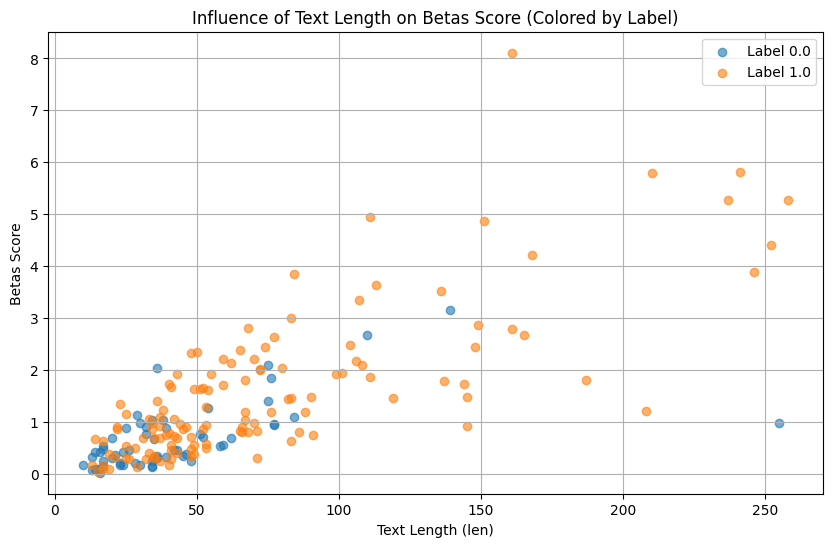

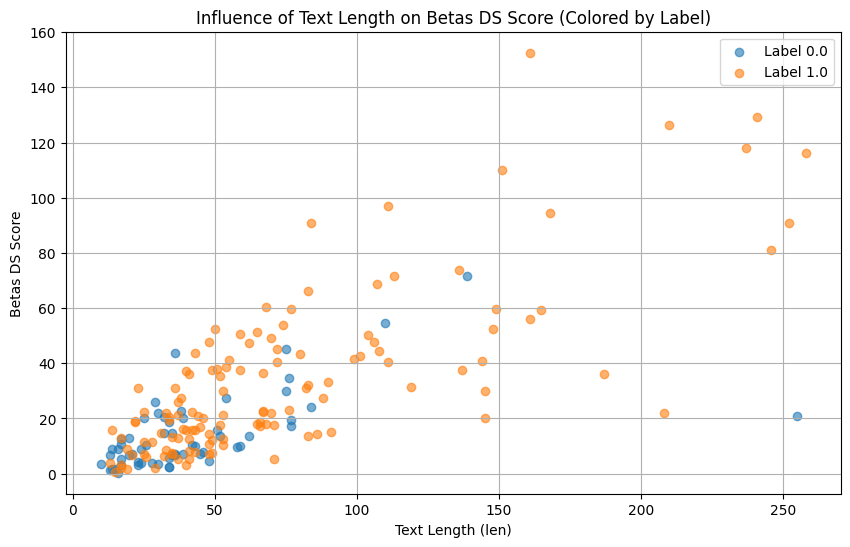

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Scatter plot for betas_score with color based on label
plt.figure(figsize=(10, 6))
for label in df['label'].unique():
    label_data = df[df['label'] == label]
    plt.scatter(label_data['len'], label_data['betas_score'], alpha=0.6, label=f'Label {label}')

plt.title('Influence of Text Length on Betas Score (Colored by Label)')
plt.xlabel('Text Length (len)')
plt.ylabel('Betas Score')
plt.legend()
plt.grid()
plt.show()

# Scatter plot for betas_ds_score with color based on label
plt.figure(figsize=(10, 6))
for label in df['label'].unique():
    label_data = df[df['label'] == label]
    plt.scatter(label_data['len'], label_data['betas_ds_score'], alpha=0.6, label=f'Label {label}')

plt.title('Influence of Text Length on Betas DS Score (Colored by Label)')
plt.xlabel('Text Length (len)')
plt.ylabel('Betas DS Score')
plt.legend()
plt.grid()
plt.show()

In [54]:
doc_id = 0
doc = documents_texts[doc_id]
" ".join(doc)

'order avoid future allergic_reaction range vomit hive anaphylactic_shock rani family need remain_vigilant avoid exposure allergen time rani food option increase list food allergic grow'

In [ ]:
wd_ids = [vocab_w2id[word] for word in documents_texts[doc] if word in vocab_w2id]

# Sumar los puntajes de las palabras para este documento
total_score = np.sum(betas_word_ds[wd_ids])

# Longitud del documento
doc_length = len(wd_ids)

# Normalizar por longitud del documento
normalized_score = total_score / (np.log(doc_length + epsilon) + 1)  # +1 para evitar división por cero

# Detectar nombres de personas en el documento
words_in_doc = [word for word in documents_texts[doc]]  # Lista de palabras en el documento
num_person_names = contains_person_names_spacy(words_in_doc)  # Número de nombres detectados

# Aplicar penalización proporcional al número de nombres detectados
if num_person_names > 0:
    normalized_score *= max(0, 1 - penalty_factor * num_person_names)  # Penalización proporcional

# Almacenar el puntaje normalizado
doc_score_ds_ent[doc] = normalized_score

In [53]:
for word in documents_texts[doc_id]:
    if word in vocab_w2id:
        print(word, vocab_w2id[word], betas_word_ds[vocab_w2id[word]]) 

avoid 0 0.01518855895525788
future 1 0.007075782373863557
range 4 0.029942063833659053
vomit 5 0.0043703671269469824
hive 6 0.004100784690459399
rani 9 9.407771505861124e-05
family 10 0.16573373732358457
avoid 0 0.01518855895525788
exposure 13 0.04098604581707421
allergen 14 0.011010291997882568
time 15 0.03347582936063808
rani 9 9.407771505861124e-05
food 16 0.24282439474689363
option 17 0.028692415206818585
increase 18 0.07602836544012638
list 19 0.01142282612854824
food 16 0.24282439474689363
allergic 2 0.021505467337092996
grow 20 0.006889252873240599


In [66]:
for word in test:
    if word in vocab_w2id:
        print(word, vocab_w2id[word], betas_word[vocab_w2id[word]]) 

doctor 41 0.026872768643336934


In [40]:
wd_ids = [vocab_w2id[word] for word in documents_texts[doc_id] if word in vocab_w2id]
for el in zip(doc, betas_word[wd_ids]):
    print(el)

('order', np.float64(0.0020543473043842073))
('avoid', np.float64(0.0013340112047585872))
('future', np.float64(0.00467892651555532))
('allergic_reaction', np.float64(0.000356352507945861))
('range', np.float64(0.00026247226231166976))
('vomit', np.float64(6.653496657107157e-06))
('hive', np.float64(0.022101814611910325))
('anaphylactic_shock', np.float64(0.0020543473043842073))
('rani', np.float64(0.004230632851925606))
('family', np.float64(0.0007406907307985468))
('need', np.float64(0.009606632585977203))
('remain_vigilant', np.float64(6.653496657107157e-06))
('avoid', np.float64(0.02121408701795172))
('exposure', np.float64(0.0029407181007598954))
('allergen', np.float64(0.012189544117707467))
('time', np.float64(0.0020543699656348576))
('rani', np.float64(0.02121408701795172))
('food', np.float64(0.0016126901750358848))
('option', np.float64(0.0018359736952052752))


In [26]:
indices_path = "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/indices"
client = chromadb.PersistentClient(path=indices_path)

In [27]:
df_en = pd.read_parquet("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/df_en.parquet")
df_en.columns

Index(['id_top', 'doc_id', 'id_preproc', 'document_id', 'text', 'len',
       'full_doc', 'human_labeled', 'lemmas', 'lemmas_tr', 'text_tr', 'lang',
       'final_label', 'common_id', 'thetas', 's3', 'top_k', 'main_topic',
       's3_main_topic', 's3_keep_doc'],
      dtype='object')

In [28]:
df_en_tpc = df_en[df_en.main_topic == 0].copy()
df_en_tpc[["text", "top_k", "main_topic", "s3_main_topic", "s3_keep_doc"]]

,text,top_k,main_topic,s3_main_topic,s3_keep_doc
19,Prevention: Avoid or reduce the use of alcohol. Get prompt medical treatment for symptoms of alcohol withdrawal.,"[[0.0, 0.7272727272727273], [4.0, 0.09090909090909091]]",0,0.067057,True
21,"Results are considered “screen negative” if the risk for Down syndrome is less than one in 110 (for example, one in 150 or one in 200). Keep in mind that screening tests cannot diagnose or rule out specific conditions, only measure the chances of one affecting your baby.","[[0.0, 0.3103448198787096], [6.0, 0.27586207204851615]]",0,0.049260,True
23,"Healthcare providers, health plans, delivery systems, and information technologies all play a role in supporting children’s healthy growth and the prevention and treatment of obesity.","[[0.0, 0.28125], [7.0, 0.28125]]",0,0.092564,True
28,"If a male has Zika he can pass the virus to his partner through unprotected sex. This can increase the chance of birth defects in his partner’s pregnancy. Males who might have been exposed to Zika virus should use condoms and wait at least 3 months before trying to conceive a pregnancy, even if they do not have symptoms.","[[0.0, 0.47916666655025136], [3.0, 0.3541666639891142]]",0,0.099530,True
29,Wound care: Your healthcare provider will instruct you on how to clean and change your dressing daily.,"[[0.0, 0.5882352989386108], [8.0, 0.3529411734027022]]",0,0.030304,True
...,...,...,...,...,...
1393054,"Can you get pregnant after menopause: Once your menstrual period has been absent for over a year, you are unlikely to get pregnant. Until your healthcare provider has confirmed you are no longer ovulating and can’t get pregnant, continue to use birth control if you don't want to become pregnant.","[[0.0, 0.8611111076962616], [3.0, 0.08333333612730107]]",0,0.051973,True
1393075,"Follow-up: If your child has been seen at a hospital, they must have a follow-up appointment scheduled. Ask the health care provider working with your child to schedule a follow-up appointment.","[[0.0, 0.869565211560415], [7.0, 0.04347826281319499]]",0,0.145272,True
1393086,2. Check your child's blood pressure using standard testing equipment. Your child's hearing may be checked.,"[[0.0, 0.3999999985098839], [9.0, 0.19999999925494194]]",0,0.030845,True
1393089,"If that doesn’t work, what are the best treatments: Talk with your pediatrician first. For infants, breastfeeding gives protection against allergies. But there are some great over-the-counter treatments available for school age and older kids including nasal sprays like Flonase and Nasacort and antihistamines such as Claritin, Zyrtec, Allegra, etc.","[[0.0, 0.7173913054411178], [2.0, 0.13043478009817394]]",0,0.074275,True


In [51]:
collection = client.get_collection(name="docs_0_es")

In [62]:
template_path = "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/templates/1_instruction_prompt.txt"
system_template_path = "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/templates/1_system_prompt.txt"
llm_model = "llama3:70b-instruct" #"llama3:70b" # llama3.1:8b-instruct-q8_0
with open(template_path, 'r') as file:
    template = file.read()

In [66]:
question = template.format(passage=df_en.iloc[1].text, full_document=(df_en.iloc[1].full_doc[:500]+ " [...]"))
print(question)

System message:

Your input fields are:
1. `PASSAGE` (str)
2. `FULL_DOCUMENT` (str)

Your output fields are:
1. `reasoning` (str)
2. `QUESTIONS` (str): YES/NO questions separated by `\n`extracted from the provided `PASSAGE`, if the `PASSAGE` contains objective information that can be transformed into YES/NO questions. Otherwise, leave this field empty.

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## PASSAGE ## ]]
{PASSAGE}

[[ ## FULL_DOCUMENT ## ]]
{FULL_DOCUMENT}

[[ ## reasoning ## ]]
{reasoning}

[[ ## QUESTIONS ## ]]
{QUESTIONS}

[[ ## completed ## ]]

In adhering to this structure, your objective is:
    1. Determine whether the provided PASSAGE within the given context provides objective information that can be transformed into YES/NO questions. People experiences, opinions, or subjective information should not be used to generate questions.
    2. If the PASSAGE contains objective information, generate YES/NO questions fr

In [67]:
prompter = Prompter(
    model_type=llm_model,
)

questions, _ = prompter.prompt(
    system_prompt_template_path=system_template_path,
    question=question
)

Cache miss: computing results...


In [68]:
questions

'[[ ## reasoning ## ]]\nThe passage provides objective information about the affiliations of authors Shinyi Wu and Paul Di Capua.\n\n[[ ## QUESTIONS ## ]]\nIs Shinyi Wu affiliated with the University of Southern California?\\nIs Paul Di Capua affiliated with the University of California, Los Angeles?\\nDoes Shinyi Wu have a PhD degree?\n\n[[ ## completed ## ]]'

In [12]:
[el.strip() for el in questions.split("---") if len(el.strip()) > 1]

['Are children diagnosed with Multisystem Inflammatory Syndrome in Children (MIS-C) often between the ages of 5 and 11 years old?',
 'Can Multisystem Inflammatory Syndrome in Children (MIS-C) affect children as young as 1 year old?',
 'Have cases of Multisystem Inflammatory Syndrome in Children (MIS-C) been reported among older children and babies?',
 'Is Multisystem Inflammatory Syndrome in Children (MIS-C) a rare condition?',
 'Can Multisystem Inflammatory Syndrome in Children (MIS-C) lead to severe problems with vital organs, such as the heart?',
 'Does early diagnosis and treatment of Multisystem Inflammatory Syndrome in Children (MIS-C) prevent permanent damage or death?',
 'Are COVID-19 vaccines effective in preventing Multisystem Inflammatory Syndrome in Children (MIS-C)?',
 'Can following precautions such as handwashing, social distancing, and wearing masks help prevent the spread of COVID-19 and Multisystem Inflammatory Syndrome in Children (MIS-C)?',
 'Is it possible for chil

In [ ]:
"""
from sklearn.svm import OneClassSVM
from sentence_transformers import SentenceTransformer

trf_model = SentenceTransformer('all-MiniLM-L6-v2')

path_tr_data="/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/tr_data/questions_rosie/FullTrialQa7152024.csv"
df_positive = pd.read_csv(path_tr_data)
df_filtered = df_positive.dropna(
    subset=['question', 'answerPassageText'])
positive_questions = list(
    set(df_filtered[['question', 'answerPassageText']].question.values.tolist()))

ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
ocsvm.fit(trf_model.encode(positive_questions))
"""

In [ ]:
for question in [el.strip() for el in questions.split("---") if len(el.strip()) > 1]:
    print(question, ocsvm.predict(trf_model.encode([question])))

In [14]:
LLM_MODEL_EMBEDDINGS = 'mxbai-embed-large:latest'
BATCH_SIZE = 512
EMBEDDING_URL = "http://kumo01.tsc.uc3m.es:11434/api/embeddings"

# Initialize embedding function
embedding_function = OllamaEmbeddingFunction(
    model_name=LLM_MODEL_EMBEDDINGS,
    url=EMBEDDING_URL,
)

In [15]:
embedding = embedding_function("Are children diagnosed with Multisystem Inflammatory Syndrome in Children (MIS-C) often between the ages of 5 and 11 years old?")[0]
print(type(embedding))
print(embedding)

results = collection.query(
    query_embeddings=[embedding.tolist()],  # Convert the numpy array to a Python list and wrap in a list
    n_results=6
)
results

<class 'numpy.ndarray'>
[0.14232633 1.1843396  0.24204206 ... 0.18227723 0.8108455  0.04077638]


{'ids': [['1062876', '425083', '1007652', '204490', '74479', '634694']],
 'embeddings': None,
 'documents': [['A algunos padres les incomoda la idea de recibir un informe escolar del IMC de sus hijos. Pero los niños con sobrepeso tienen más probabilidades de desarrollar problemas de salud, como la hipertensión (tensión arterial alta) y la diabetes. Los padres deben compartir el informe escolar del IMC con el médico de sus hijos, quien les puede ayudar a interpretar los resultados y darles recomendaciones.',
   'Síntomas: Los niños tienen más probabilidades que los adultos de presentar síntomas de una infección por E. coli. La mayoría de las personas con la infección tendrán:',
   '¿Cuáles son los síntomas de la faringitis y la amigdalitis en los niños: Los síntomas pueden presentarse de forma un poco diferente en cada niño. Pueden incluir los siguientes:',
   '¿Cuáles son los síntomas de la endocarditis bacteriana en los niños: Los síntomas pueden presentarse de forma un poco diferente